# Generate a circuit

A minimal example to generate a circuit. We load a pre-trained (SRV, 3 to 8 qubit) model and condition on a given Schmidt-Rank-Vector (SRV).

In [ ]:
from genQC.imports import *
from genQC.pipeline.diffusion_pipeline import DiffusionPipeline
import genQC.inference.infer_srv as infer_srv
import genQC.util as util

In [ ]:
device = util.infer_torch_device()  # use cuda if we can
util.MemoryCleaner.purge_mem()      # clean existing memory alloc

[INFO]: Cuda device has a capability of 8.6 (>= 8), allowing tf32 matmul.


In [ ]:
device

device(type='cuda')

## Setup and load

Load the pre-trained model

In [ ]:
model_path = "../../saves/qc_unet_config_SRV_3to8_qubit/"
pipeline   = DiffusionPipeline.from_config_file(model_path, device)  

[INFO]: `genQC.models.unet_qc.QC_Cond_UNet` instantiated from given config on cuda.
[INFO]: `genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder` instantiated from given config on cuda.
[INFO]: `genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder`. No save_path` provided. No state dict loaded.


Check on what gates the model was trained

In [ ]:
pipeline.gate_pool

[qiskit.circuit.library.standard_gates.h.HGate,
 qiskit.circuit.library.standard_gates.x.CXGate]

Set 20 sample steps and use rescaled guidance-formula.

In [ ]:
pipeline.guidance_sample_mode = "rescaled"
pipeline.scheduler.set_timesteps(20) 

## Inference / sampling

Set our desired condition SRV

In [ ]:
srv           = [2, 1, 2, 1, 2]  # set your target SRV; can be 3 to 8 qubit
num_of_qubits = len(srv)          

prompt = f"Generate SRV: {srv}"  # model was trained with this phrase
prompt

'Generate SRV: [2, 1, 2, 1, 2]'

Define sample parameters

In [ ]:
g         = 7.5     # guidance scale
max_gates = 16      # how many time steps the tensor encoding has
samples   = 64      # how many circuits to generate

Sample tokenized circuits

In [ ]:
out_tensor = infer_srv.generate_srv_tensors(pipeline, prompt, samples, num_of_qubits, num_of_qubits, max_gates, g, no_bar=False) 

  0%|          | 0/20 [00:00<?, ?it/s]

[INFO]: (generate_srv_tensors) Generated 64 tensors


Check how many distinct tensors we got:

In [ ]:
out_tensor.unique(dim=0).shape[0]

64

Let's look what is generated. Note, 3 is the padding token (or empty action).

In [ ]:
out_tensor[:2]

tensor([[[ 0,  2,  0,  2,  0,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
         [ 0,  0,  0,  0,  0,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
         [ 2, -2,  1, -2, -2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
         [ 0,  0,  0,  0,  0,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
         [-2,  0,  0,  0,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3]],

        [[ 0,  0,  0,  2,  0,  0,  0,  0,  3,  3,  3,  3,  3,  3,  3,  3],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  3,  3,  3,  3,  3,  3,  3,  3],
         [ 1, -2,  1, -2,  1,  0, -2,  0,  3,  3,  3,  3,  3,  3,  3,  3],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  3,  3,  3,  3,  3,  3,  3,  3],
         [ 0,  2,  0,  0,  0,  1,  2,  1,  3,  3,  3,  3,  3,  3,  3,  3]]])

## Convert to qiskit circuit 

To get a qiskit circuit we need to do: 

- apply cosine similarity to go from embeddings to token matrices (the function `infer_srv.generate_srv_tensors` did this already)
- parse token matrix to qiskit and filter out error circuits
- calculate SRV and plot circuits

In [ ]:
qc_list, error_cnt, srv_list = infer_srv.convert_tensors_to_srvs(out_tensor, pipeline.gate_pool)

Generated error circuits (token matrices that don't correspond to circuits):

In [ ]:
error_cnt

0

What SRVs did we get:

In [ ]:
srv_list[:4]

[[2, 1, 2, 1, 2], [2, 1, 2, 1, 2], [2, 1, 2, 1, 2], [2, 1, 2, 1, 2]]

That is an accuracy of:

In [ ]:
sum(srv==x for x in srv_list)/len(srv_list)

0.921875

Finally plot some of the circuits:

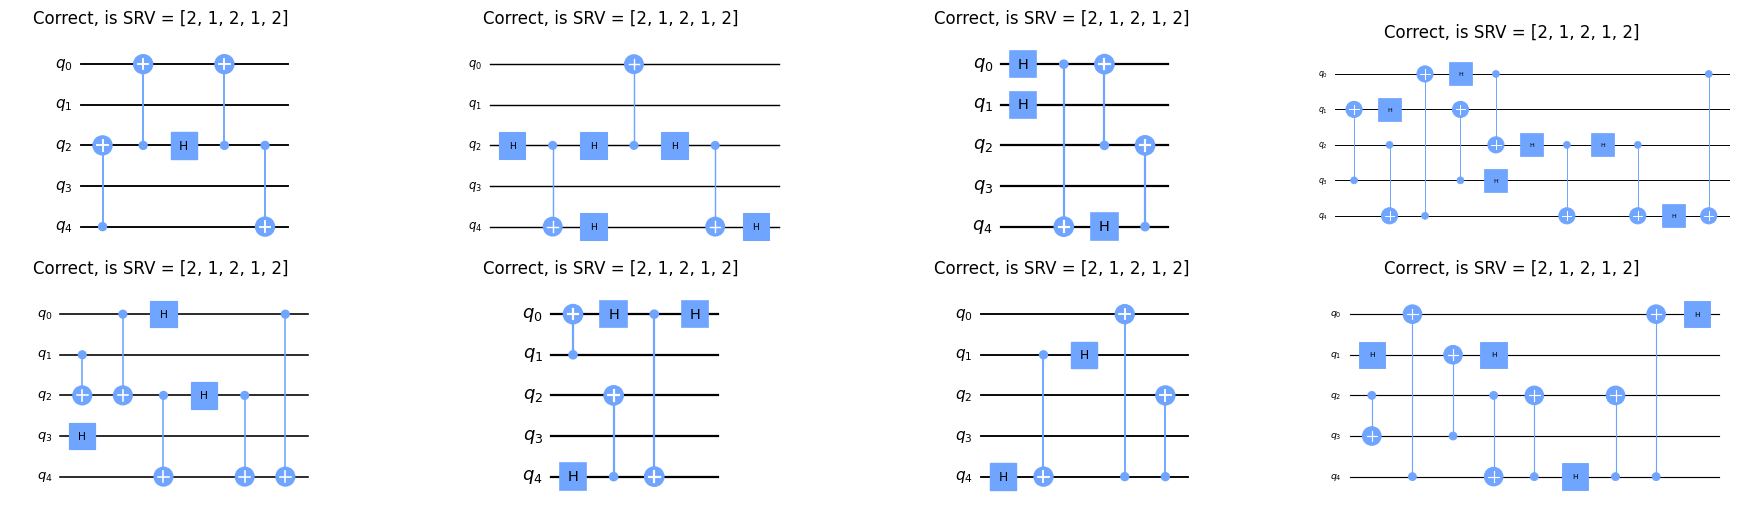

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(18,5), constrained_layout=True)
for qc,is_svr,ax in zip(qc_list, srv_list, axs.flatten()): 
    qc.draw("mpl", plot_barriers=False, ax=ax, style = "clifford")
    ax.set_title(f"{'Correct' if is_svr==srv else 'NOT correct'}, is SRV = {is_svr}")
plt.show()